# Определение возраста покупателей

## 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузим и изучим данные.

In [2]:
data=pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет, типы данных соответствуют.

In [5]:
data.duplicated().sum()

0

Дубликатов нет.

### Вывод

С данными всё в порядке, они не требуют обработки.

Пропусков нет, типы данных соответствуют.

Дубликатов нет.

### Оценим распределение возраста.

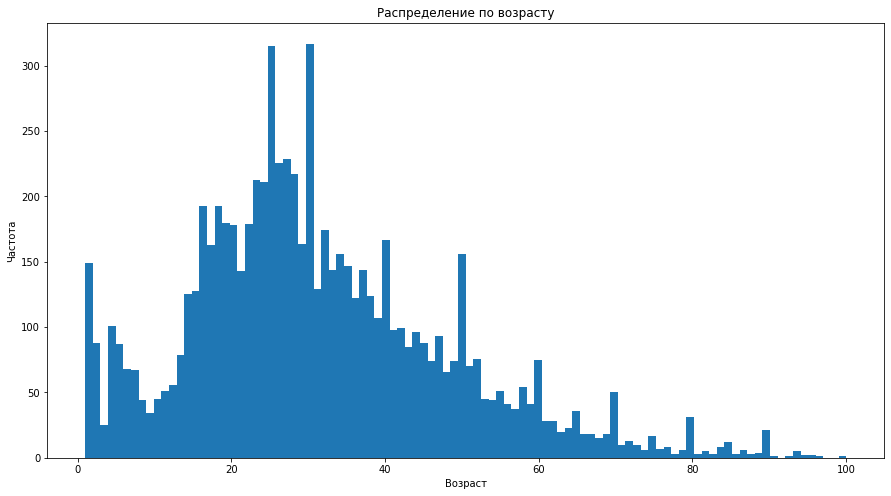

In [6]:
plt.figure(figsize=(15, 8))
plt.hist(data.real_age, bins=100)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение по возрасту')
plt.show()

In [7]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Вывод

Большая часть данных распределена в промежутке от 20 до 41 года.

### Загрузим примеры изображений из тренировочной выборки

Воспользуемся функциями.

In [8]:
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        data,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='training',
        interpolation='nearest',
        validate_filenames=True)

    return train_datagen_flow

Загрузим данные в переменные.

In [9]:
train_datagen_flow = load_train('/datasets/faces/final_files/')
features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


Выведем на экран 12 изображений и соответствующий им целевой признак.

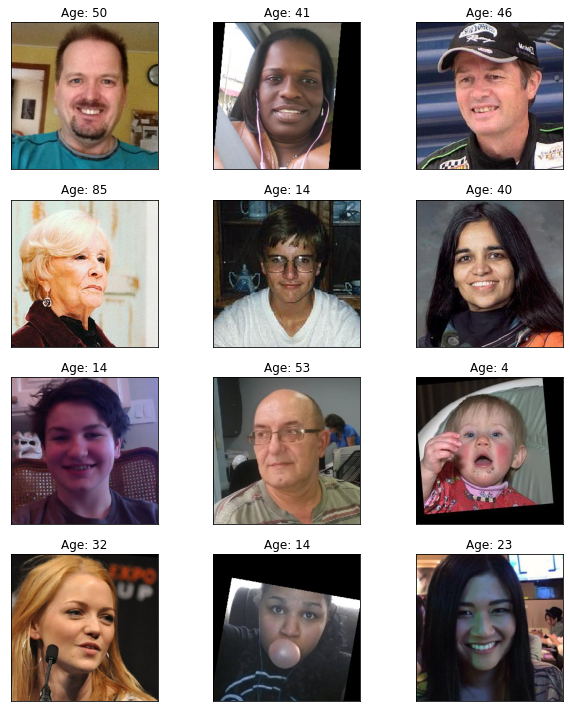

In [10]:
# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title('Age: '+ str(target[i]))
    plt.tight_layout()

### Вывод

По представленным фото трудно точно указать возраст.

На некоторых изображениях имеется поворот и сдвиг.

Освещение также добавляет шум в фото в виде дополнительных теней и светлого заднего фона.

На заднем фоне присутствуют другие люди.

На некотоных фото имеются объекты перекрывающие лицо человека - микрофон, жвачка.

## 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

RANDOM_STATE=12345

def load_train(path):
    
    labels=pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.2,
        vertical_flip=True,
        horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        seed=RANDOM_STATE,
        subset='training')

    return train_datagen_flow

def load_test(path):

    labels=pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        rescale=1/255.,
        validation_split=0.2)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        seed=RANDOM_STATE,
        subset='validation')

    return test_datagen_flow


def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet', 
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'])

    return model


def train_model(
        model,
        train_data,
        test_data,
        batch_size=None,
        epochs=10,
        steps_per_epoch=None,
        validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True)
    return model


```

```

Found 6073 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 60 steps
Epoch 1/10
190/190 - 52s - loss: 776.3419 - mae: 23.1719 - val_loss: 1059.4589 - val_mae: 27.9341
Epoch 2/10
190/190 - 43s - loss: 180.2607 - mae: 10.2306 - val_loss: 993.5210 - val_mae: 26.8010
Epoch 3/10
190/190 - 43s - loss: 76.3315 - mae: 6.5490 - val_loss: 812.2919 - val_mae: 23.5461
Epoch 4/10
190/190 - 42s - loss: 39.7271 - mae: 4.7677 - val_loss: 156.8405 - val_mae: 9.3764
Epoch 5/10
190/190 - 43s - loss: 24.7288 - mae: 3.8009 - val_loss: 91.5083 - val_mae: 7.3176
Epoch 6/10
190/190 - 42s - loss: 18.2296 - mae: 3.2775 - val_loss: 74.4942 - val_mae: 6.4953
Epoch 7/10
190/190 - 42s - loss: 15.9202 - mae: 3.0484 - val_loss: 74.4748 - val_mae: 6.3425
Epoch 8/10
190/190 - 42s - loss: 14.5331 - mae: 2.9197 - val_loss: 71.0000 - val_mae: 6.1992
Epoch 9/10
190/190 - 42s - loss: 13.1493 - mae: 2.7853 - val_loss: 71.0563 - val_mae: 6.1721
Epoch 10/10
190/190 - 42s - loss: 12.1576 - mae: 2.6993 - val_loss: 68.3144 - val_mae: 6.0594

60/60 - 10s - loss: 68.3144 - mae: 6.0594
Test MAE: 6.0594



```

### Вывод

Нам удалось достичь метрики MAE не более 8 и выполнить условия задания.

## 3. Анализ обученной модели

Модель способна обрабатывать большой объем данных и давать хороший результат.

Однако для практического применения модель придётся доучивать, изменять её параметры, а рассмотренного датасета недостаточно.

Перед нами стояли задачи:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Поэтому в качестве рекомендательной системы модель может использоваться, для предложения товаров соответствующих какому-то возрастному диапазону.

А вот точность в 6 лет - не позволяет достоверно использовать модель для контроля продажи алкоголя - здесь с такой точностью без контроля кассиром не обойтись.

Учитывая, что для самого изучаемого датасета MAE равно 5.4, мы добились неплоходго результата достигнув MAE 6.0594